In [1]:
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import ipywidgets
# import kliplab
import pprint

from matplotlib.colors import LogNorm
from ipywidgets import *

%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.linewidth'] = 3.
matplotlib.rcParams['font.size'] = 22

import sys
# codefolder = os.path.expanduser('~/WFIRST_tech/crispy')
# if codefolder not in sys.path: sys.path.append(codefolder)
folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

import numpy as np
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

from crispy.params import Params
#codefolder = '../../../crispy'

../../../../crispy


In [2]:
# sys.path.append(os.path.join(codefolder,'crispy'))
# sys.path.append(os.path.join(codefolder,'crispy/tools'))

In [2]:

from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf


In [3]:
%ls

Accessory function tests.ipynb          PISCES_wavecalWithAverages.ipynb
CGI-IFS.ipynb                           RDI_sensitivity.ipynb
CodeCharacterization.ipynb              RDI_sensitivity_study.ipynb
Compare_Shifting_Methods.ipynb          Reduction tests.ipynb
ConstructFiducials.ipynb                Residual_Minimization_Idea.ipynb
DetectorSNR.ipynb                       SPIE_Images.ipynb
DetectorTesting.ipynb                   ShapedPupilIFS.ipynb
Experimenting with least squares.ipynb  ShapedPupilIFS2.ipynb
GaussianOverlap.ipynb                   Software walkthrough.ipynb
HaystacksProcessing.ipynb               TestCalibration.ipynb
IFS.ipynb                               Traps.ipynb
InputSceneTests.ipynb                   TrapsExperiments.ipynb
Introduction.ipynb                      Untitled.ipynb
Matched_Filter_scratch.ipynb            Untitled1.ipynb
Matched_filtering.ipynb                 Untitled2.ipynb
MultiProcExample.ipynb                  Wavecal.ipynb
OS5_scenario.ipy

In [34]:
# %ls 'Noiseless/'

average_ref_star_detector_red_optext_flatfielded.fits
average_target_star_detector_red_optext_flatfielded.fits
average_target_star_nosource_detector_red_optext_flatfielded.fits


In [36]:
# %ls 'Noisy 3/'

average_ref_star_detector_red_optext_flatfielded.fits
average_target_star_detector_red_optext_flatfielded.fits
average_target_star_nosource_detector_red_optext_flatfielded.fits
matched_filter.fits


In [11]:
lamc=660.
BW = 0.18
par.nonoise=False
sampling=2.0
par.timeframe=1000
par.Nreads = par.timeframe/300
par.PCmode=True
par.lenslet_sampling=1./sampling
folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_t'+str(int(par.timeframe))
# folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_noiseless'
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'


In [21]:
use_noise = False
# use_noise = True

In [22]:
#ref_star = fits.getdata('Nonoise/average_ref_star_detector_red_optext_flatfielded_trimmean.fits')
#target_star = fits.getdata('Nonoise/average_target_star_nosource_detector_red_optext_flatfielded_trimmean.fits')
#target_star_planet = fits.getdata('Nonoise/average_target_star_detector_red_optext_flatfielded_trimmean.fits')
f = folder+"/average/ForNeil"
%ls /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/ForNeil/Noisy
if use_noise:
    ref_star = fits.getdata(f+'/Noisy/average_ref_star_detector_red_optext_flatfielded.fits')
    target_star = fits.getdata(f+'/Noisy/average_target_star_nosource_detector_red_optext_flatfielded.fits')    
    target_star_planet = fits.getdata(f+'/Noisy/average_target_star_detector_red_optext_flatfielded.fits')
else:
    ref_star = fits.getdata(f+'/Noiseless/average_ref_star_detector_red_optext_flatfielded.fits')
    target_star = fits.getdata(f+'/Noiseless/average_target_star_nosource_detector_red_optext_flatfielded.fits')
    target_star_planet = fits.getdata(f+'/Noiseless/average_target_star_detector_red_optext_flatfielded.fits')

matched_filter = fits.getdata(f+'/Noisy/matched_filter.fits')

average_ref_star_detector_red_optext_flatfielded.fits
average_target_star_detector_red_optext_flatfielded.fits
average_target_star_nosource_detector_red_optext_flatfielded.fits
matched_filter.fits


In [23]:
Nw = ref_star.shape[0]
imh = ref_star.shape[1]
imw = ref_star.shape[2]

In [24]:
planet = target_star_planet - target_star
planet_pos_ind = np.nanargmax(planet[-1,:,:])
xpos_planet = planet_pos_ind % imw
ypos_planet = planet_pos_ind // imh
print("x,y cube pixel planet position: {}, {}".format(xpos_planet, ypos_planet))

x,y cube pixel planet position: 61, 50


In [25]:
print(ref_star.shape)
print(matched_filter.shape)

(19, 108, 108)
(19, 108, 108)


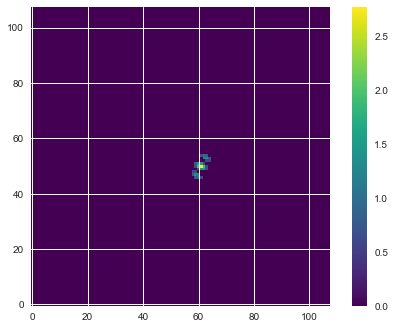

In [26]:
plt.imshow(matched_filter[10], cmap='viridis')
plt.colorbar()

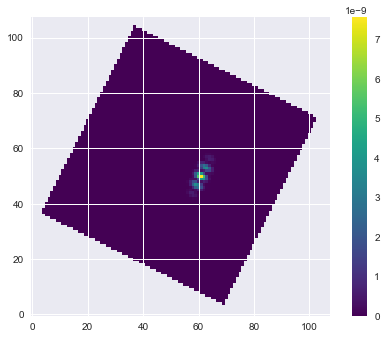

In [27]:
plt.imshow(planet[10], cmap='viridis')
plt.colorbar()

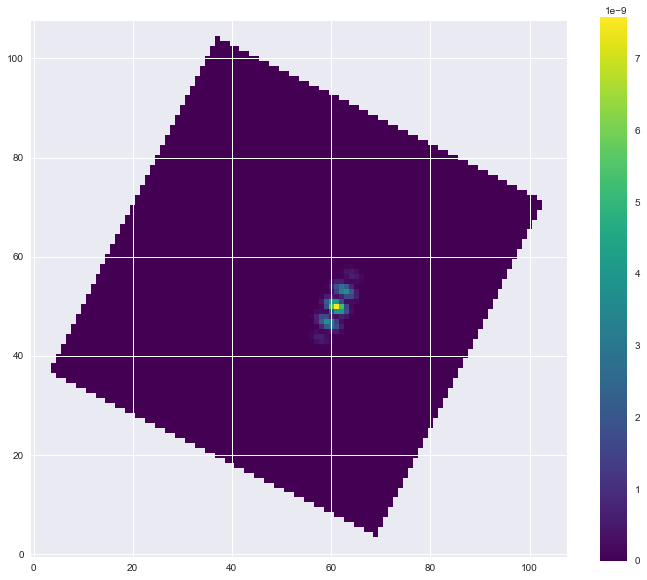

In [28]:
def plt_cube_slice(wchan):
    plt.figure(figsize=(12,10))
    plt.imshow(planet[wchan-1,:,:], cmap='viridis')
    plt.colorbar()
ipywidgets.interact(plt_cube_slice, wchan=(1,planet.shape[0]));

In [29]:
mf_planet = matched_filter*planet
true_planet_spectrum = np.nansum(np.nansum(mf_planet, axis=2), axis=1)

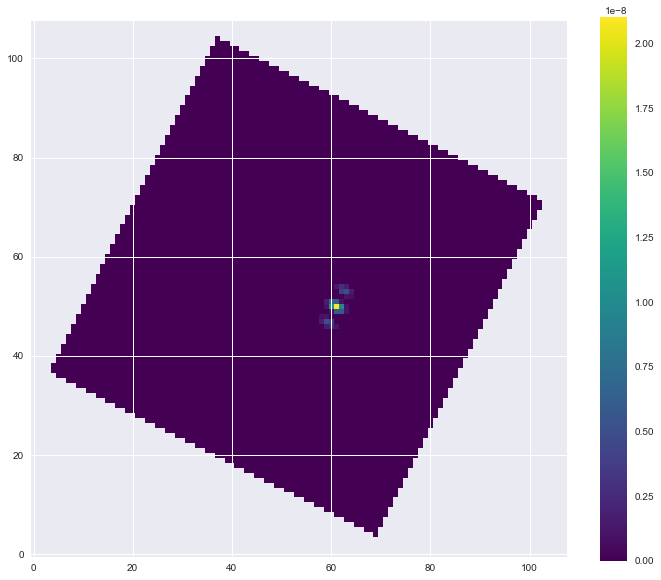

In [30]:
def plt_cube_slice(wchan):
    plt.figure(figsize=(12,10))
    plt.imshow(mf_planet[wchan-1,:,:], cmap='viridis')
    plt.colorbar()
ipywidgets.interact(plt_cube_slice, wchan=(1,mf_planet.shape[0]));

In [31]:
#IWA = 2.7
#OWA = 8.7
#ang = 60.
IWA = 2.5
OWA = 9.
ang = 65.
lamc = 660.

data_mask, scratch = bowtie(ref_star[0], imw//2-1, imh//2, openingAngle=ang,
                            clocking=-par.philens*180./np.pi,
                            IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
                            OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
                            export=None,twomasks=False)

data_ind = np.nonzero(data_mask)
nan_ind = np.nonzero(~data_mask)
N_pix = len(data_ind[0])
N_mask = len(nan_ind[0])

data_mask_nan = np.zeros(data_mask.shape)       
data_mask_nan[nan_ind[0][:], nan_ind[1][:]] = np.nan
data_mask_nan[data_ind[0][:], data_ind[1][:]] = True

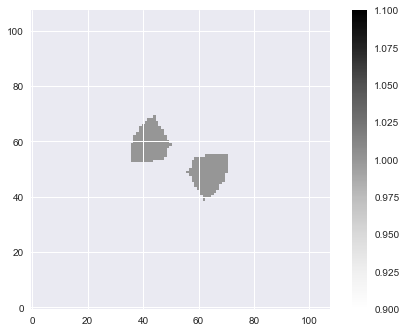

In [32]:
plt.imshow(data_mask_nan)
plt.colorbar()

1.21031e-07


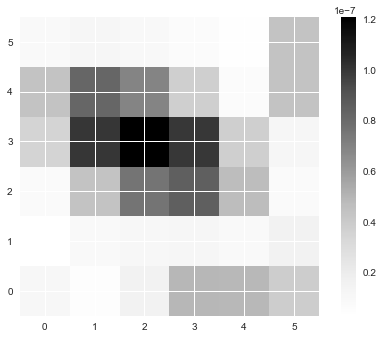

In [33]:
plt.imshow(ref_star[3, imh//2-3:imh//2+3, imw//2-3:imw//2+3])
plt.colorbar()
print(ref_star[3, imh//2, imw//2-1])

In [34]:
masked_ref_star = data_mask_nan*ref_star
masked_target_star = data_mask_nan*target_star
masked_target_star_planet = data_mask_nan*target_star_planet

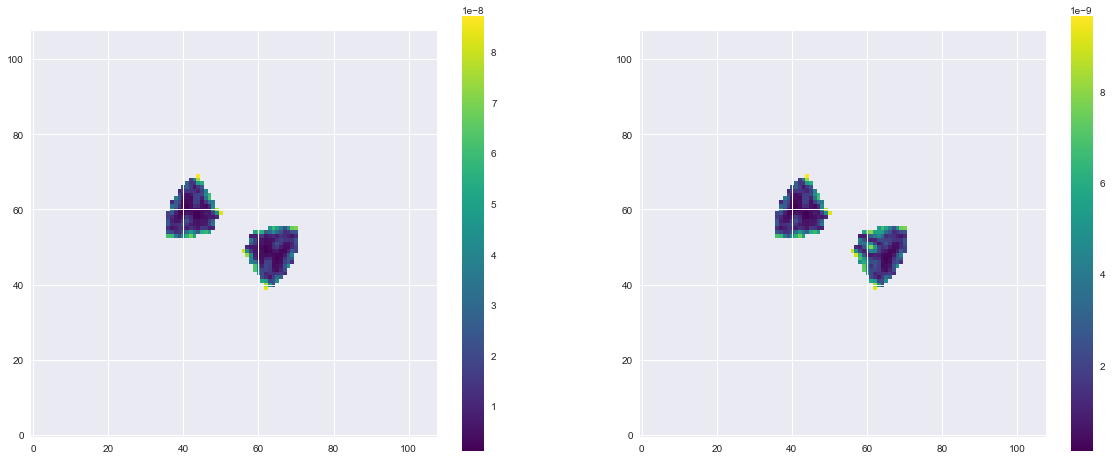

In [35]:
def plt_ref_target_cube_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(masked_ref_star[wchan-1,:,:], cmap='viridis')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(masked_target_star_planet[wchan-1,:,:], cmap='viridis')
    plt.colorbar()
ipywidgets.interact(plt_ref_target_cube_slices, wchan=(1,mf_planet.shape[0]));

In [36]:
#help(bowtie)

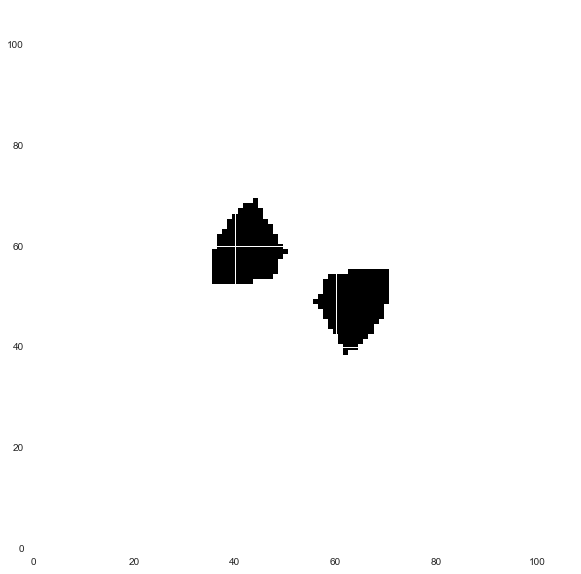

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(data_mask)

In [38]:
target_star_vec = target_star[:,data_ind[0],data_ind[1]]
target_star_planet_vec = target_star_planet[:,data_ind[0],data_ind[1]]
ref_star_vec = ref_star[:,data_ind[0],data_ind[1]]

In [39]:
target_star_vec.shape

(19, 334)

In [40]:
linregress_coeff = np.zeros((Nw, 2))
target_star_est_vec = np.zeros_like(target_star_vec)
target_star_est = np.zeros_like(ref_star)

for wi in range(Nw):
    b, a, _, _, _ = scipy.stats.linregress(ref_star_vec[wi,:], target_star_vec[wi,:])
    linregress_coeff[wi, 0] = a
    linregress_coeff[wi, 1] = b
    target_star_est_vec[wi] = a + b*ref_star_vec[wi]
    #target_star_est_vec[wi] = b*ref_star_vec[wi]

for ii in range(N_pix):
    target_star_est[:, data_ind[0][ii], data_ind[1][ii]] = target_star_est_vec[:,ii]
for ii in range(N_mask):
    target_star_est[:, nan_ind[0][ii], nan_ind[1][ii]] = np.nan

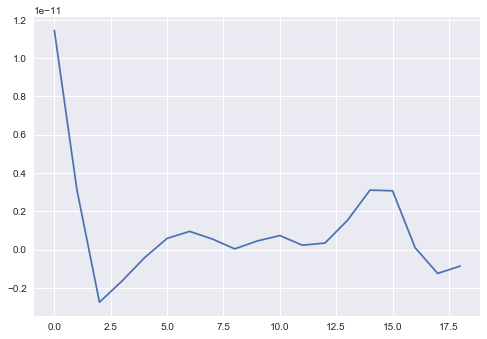

In [41]:
plt.plot(linregress_coeff[:,0])

In [42]:
rdi_planet = target_star_planet - target_star_est
mf_rdi_planet = matched_filter*rdi_planet
rdi_planet_spectrum = np.nansum(np.nansum(mf_rdi_planet, axis=2), axis=1)

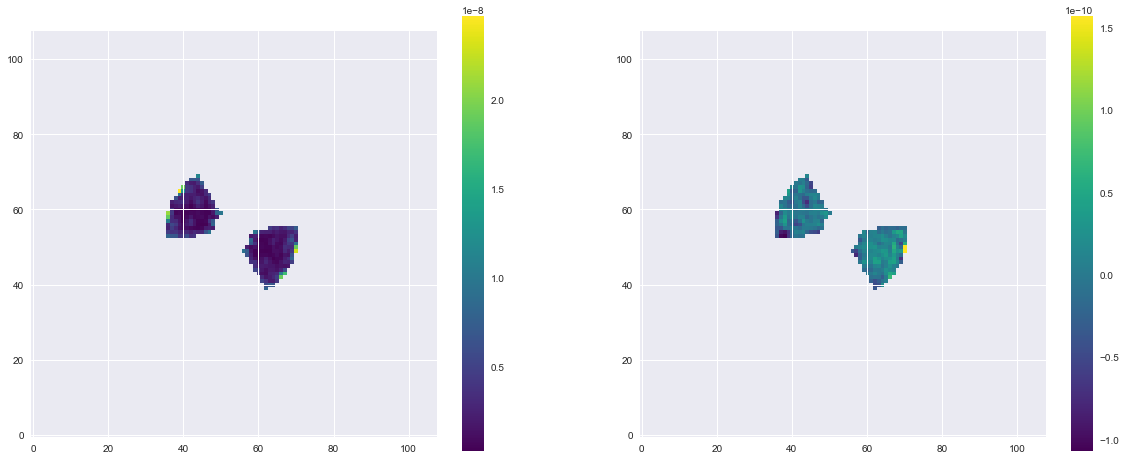

In [43]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(target_star_est[0], cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.imshow(target_star_est[0] - masked_target_star[0], cmap='viridis')
plt.colorbar()

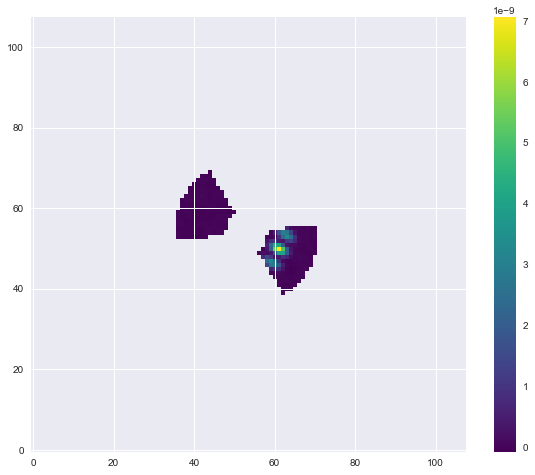

In [44]:
plt.figure(figsize=(10,8))
plt.imshow(rdi_planet[-1], cmap='viridis')
plt.colorbar()

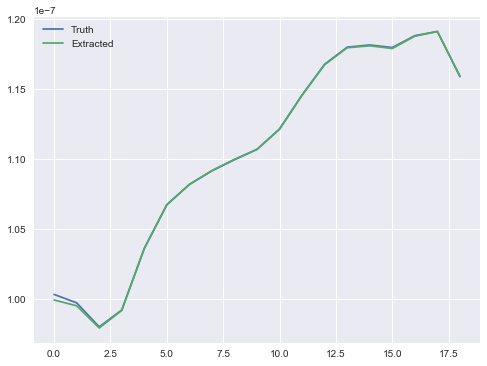

In [45]:
plt.figure(figsize=(8,6))
plt.plot(true_planet_spectrum)
plt.plot(rdi_planet_spectrum)
#plt.ylim([0,8])
plt.legend(['Truth','Extracted'])

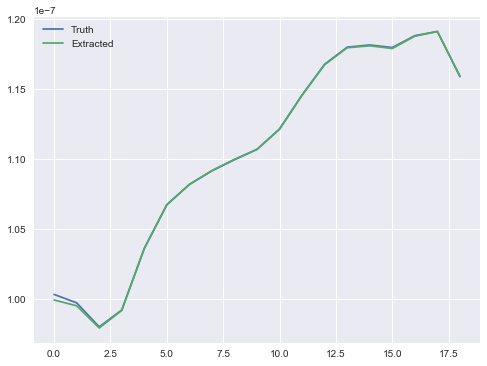

In [46]:
plt.figure(figsize=(8,6))
plt.plot(true_planet_spectrum)
plt.plot(rdi_planet_spectrum)
#plt.ylim([0,8])
plt.legend(['Truth','Extracted'])

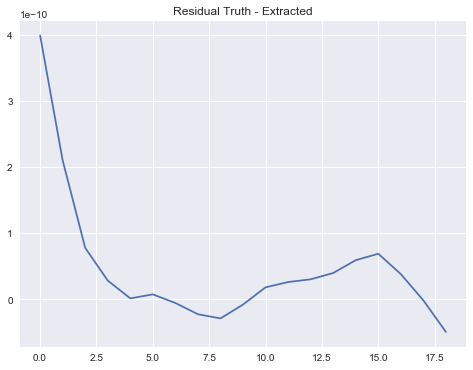

In [47]:
plt.figure(figsize=(8,6))
plt.title('Residual Truth - Extracted')
plt.plot(true_planet_spectrum - rdi_planet_spectrum)